https://www.kaggle.com/code/michaln/hotel-id-starter-similarity-training

In [1]:
import numpy as np
import pandas as pd
import random
import os

from PIL import Image as pil_image
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import timm

from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
IMG_SIZE = 256
SEED = 42
N_MATCHES = 5

PROJECT_FOLDER = "../input/hotel-id-to-combat-human-trafficking-2022-fgvc9/"
DATA_FOLDER = "../input/hotelid-2022-train-images-256x256/"
IMAGE_FOLDER = DATA_FOLDER + "images/"
OUTPUT_FOLDER = "../input/output/"

train_df = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'))

In [3]:
print(os.listdir(PROJECT_FOLDER))

['train_images', 'test_images', 'train_masks', 'sample_submission.csv']


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
import albumentations as A
import albumentations.pytorch as APT
import cv2 

# used for training dataset - augmentations and occlusions
train_transform = A.Compose([
    A.HorizontalFlip(p=0.75),
    A.VerticalFlip(p=0.25),
    A.ShiftScaleRotate(p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.OpticalDistortion(p=0.25),
    A.Perspective(p=0.25),
    A.CoarseDropout(p=0.5, min_holes=1, max_holes=6, 
                    min_height=IMG_SIZE//16, max_height=IMG_SIZE//4,
                    min_width=IMG_SIZE//16,  max_width=IMG_SIZE//4), # normal coarse dropout
    
    A.CoarseDropout(p=0.75, max_holes=1, 
                    min_height=IMG_SIZE//4, max_height=IMG_SIZE//2,
                    min_width=IMG_SIZE//4,  max_width=IMG_SIZE//2, 
                    fill_value=(255,0,0)),# simulating occlusions in test data

    A.RandomBrightnessContrast(p=0.75),
    A.ToFloat(),
    APT.transforms.ToTensorV2(),
])

# used for validation dataset - only occlusions
val_transform = A.Compose([
    A.CoarseDropout(p=0.75, max_holes=1, 
                    min_height=IMG_SIZE//4, max_height=IMG_SIZE//2,
                    min_width=IMG_SIZE//4,  max_width=IMG_SIZE//2, 
                    fill_value=(255,0,0)),# simulating occlusions
    A.ToFloat(),
    APT.transforms.ToTensorV2(),
])

# no augmentations
base_transform = A.Compose([
    A.ToFloat(),
    APT.transforms.ToTensorV2(),
])

In [6]:
class HotelTrainDataset:
    def __init__(self, data, transform=None, data_path="train_images/"):
        self.data = data
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        record = self.data.iloc[idx]
        image_path = self.data_path + record["image_id"]
        image = np.array(pil_image.open(image_path)).astype(np.uint8)

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]
        
        return {
            "image" : image,
            "target" : record['hotel_id_code'],
        }

In [27]:
class EmbeddingModel(nn.Module):
    def __init__(self, n_classes=100, embedding_size=64, backbone_name="efficientnet_b0"):
        super(EmbeddingModel, self).__init__()
        
        self.backbone = timm.create_model(backbone_name, num_classes=n_classes, pretrained=True)
        in_features = self.backbone.get_classifier().in_features
        
        self.backbone.classifier = nn.Identity()
        self.embedding = nn.Linear(in_features, embedding_size)
        self.classifier = nn.Linear(embedding_size, n_classes)

    def embed_and_classify(self, x):
        x = self.forward(x)
        return x, self.classifier(x)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        return x

In [29]:
# method to iterate loader and generate embeddings of images
# returns embeddings and image class
def generate_embeddings(loader, model, bar_desc="Generating embeds"):
    targets_all = []
    outputs_all = []
    
    model.eval()
    with torch.no_grad():
        t = tqdm(loader, desc=bar_desc)
        for i, sample in enumerate(t):
            input = sample['image'].to(args.device)
            target = sample['target'].to(args.device)
            output = model(input)
            
            targets_all.extend(target.cpu().numpy())
            outputs_all.extend(output.detach().cpu().numpy())

    targets_all = np.array(targets_all).astype(np.float32)
    outputs_all = np.array(outputs_all).astype(np.float32)
            
    return outputs_all, targets_all

In [30]:
def save_checkpoint(model, scheduler, optimizer, epoch, name, loss=None, score=None):
    checkpoint = {"epoch": epoch,
                  "model": model.state_dict(),
                  "scheduler": scheduler.state_dict(),
                  "optimizer": optimizer.state_dict(),
                  "loss": loss,
                  "score": score,
                  }

    torch.save(checkpoint, f"{OUTPUT_FOLDER}checkpoint-{name}.pt")


def load_checkpoint(model, scheduler, optimizer, name):
    checkpoint = torch.load(f"{OUTPUT_FOLDER}checkpoint-{name}.pt")

    model.load_state_dict(checkpoint["model"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    return model, scheduler, optimizer, checkpoint["epoch"]

In [31]:
def train_epoch(args, model, loader, criterion, optimizer, scheduler, epoch):
    losses = []
    targets_all = []
    outputs_all = []
    
    model.train()
    t = tqdm(loader)
    
    for i, sample in enumerate(t):
        optimizer.zero_grad()
        
        images = sample['image'].to(args.device)
        targets = sample['target'].to(args.device)
        
        _, outputs = model.embed_and_classify(images)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
                
        losses.append(loss.item())
        targets_all.extend(targets.cpu().numpy())
        outputs_all.extend(torch.sigmoid(outputs).detach().cpu().numpy())

        score = np.mean(targets_all == np.argmax(outputs_all, axis=1))
        desc = f"Training epoch {epoch}/{args.epochs} - loss:{loss:0.4f}, accuracy: {score:0.4f}"
        t.set_description(desc)
        
    return np.mean(losses), score

In [32]:
def test_classification(loader, model):
    targets_all = []
    outputs_all = []
    
    model.eval()
    t = tqdm(loader, desc="Classification")
    
    for i, sample in enumerate(t):
        images = sample['image'].to(args.device)
        targets = sample['target'].to(args.device)
        
        _, outputs = model.embed_and_classify(images)
        
        targets_all.extend(targets.cpu().numpy())
        outputs_all.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        
    
    # repeat targets to N_MATCHES for easy calculation of MAP@5
    y = np.repeat([targets_all], repeats=N_MATCHES, axis=0).T
    # sort predictions and get top 5
    preds = np.argsort(-np.array(outputs_all), axis=1)[:, :N_MATCHES]
    # check if any of top 5 predictions are correct and calculate mean accuracy
    acc_top_5 = (preds == y).any(axis=1).mean()
    # calculate prediction accuracy
    acc_top_1 = np.mean(targets_all == np.argmax(outputs_all, axis=1))

    print(f"Classification accuracy: {acc_top_1:0.4f}, MAP@5: {acc_top_5:0.4f}")

In [33]:
# find 5 most similar images from different hotels and return their hotel_id_code
def find_matches(query, base_embeds, base_targets, k=N_MATCHES):
    distance_df = pd.DataFrame(index=np.arange(len(base_targets)), data={"hotel_id_code": base_targets})
    # calculate cosine distance of query embeds to all base embeds
    distance_df["distance"] = cosine_similarity([query], base_embeds)[0]
    # sort by distance and hotel_id
    distance_df = distance_df.sort_values(by=["distance", "hotel_id_code"], ascending=False).reset_index(drop=True)
    # return first 5 different hotel_id_codes
    return distance_df["hotel_id_code"].unique()[:N_MATCHES]
    

def test_similarity(args, base_loader, test_loader, model):
    base_embeds, base_targets = generate_embeddings(base_loader, model, "Generate base embeddings")
    test_embeds, test_targets = generate_embeddings(test_loader, model, "Generate test embeddings")
    
    preds = []
    for query_embeds in tqdm(test_embeds, desc="Similarity - match finding"):
        tmp = find_matches(query_embeds, base_embeds, base_targets)
        preds.extend([tmp])
        
    preds = np.array(preds)
    test_targets_N = np.repeat([test_targets], repeats=N_MATCHES, axis=0).T
    # check if any of top 5 predictions are correct and calculate mean accuracy
    acc_top_5 = (preds == test_targets_N).any(axis=1).mean()
    # calculate prediction accuracy
    acc_top_1 = np.mean(test_targets == preds[:, 0])
    print(f"Similarity accuracy: {acc_top_1:0.4f}, MAP@5: {acc_top_5:0.4f}")

In [34]:
data_df = pd.read_csv(DATA_FOLDER + "train.csv")
# encode hotel ids
data_df["hotel_id_code"] = data_df["hotel_id"].astype('category').cat.codes.values.astype(np.int64)

In [36]:
# save hotel_id encoding for later decoding
hotel_id_code_df = data_df.drop(columns=["image_id"]).drop_duplicates().reset_index(drop=True)
hotel_id_code_df.to_csv(OUTPUT_FOLDER + 'hotel_id_code_mapping.csv', index=False)
# hotel_id_code_map = hotel_id_code_df.set_index('hotel_id_code').to_dict()["hotel_id"]

In [37]:
def show_images(ds, title_text, n_images=5):
    fig, ax = plt.subplots(1,5, figsize=(22,8))
    
    ax[0].set_ylabel(title_text)
    
    for i in range(5):
        d = ds.__getitem__(i)
        ax[i].imshow(d["image"].T)

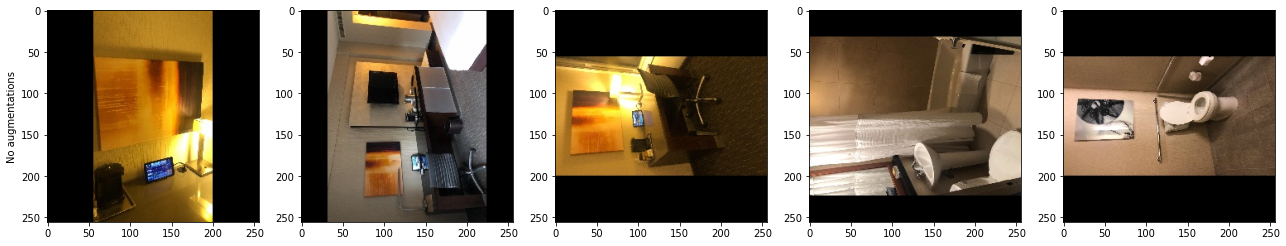

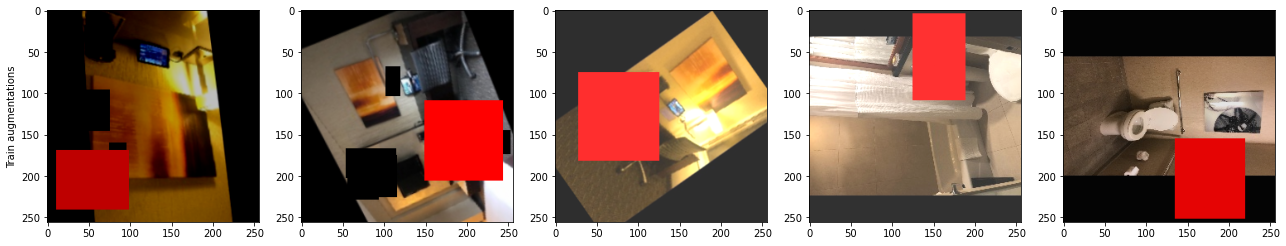

In [38]:
train_dataset = HotelTrainDataset(data_df, base_transform, data_path=IMAGE_FOLDER)
show_images(train_dataset, 'No augmentations')

train_dataset = HotelTrainDataset(data_df, train_transform, data_path=IMAGE_FOLDER)
show_images(train_dataset, 'Train augmentations')

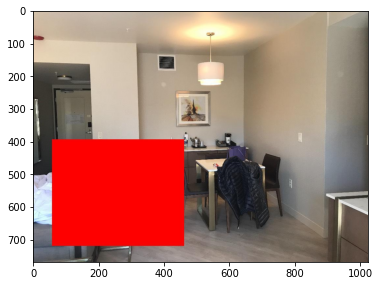

In [39]:
test_image = np.array(pil_image.open('../input/hotel-id-to-combat-human-trafficking-2022-fgvc9/test_images/abc.jpg')).astype(np.uint8)
plt.figure(figsize=(6,6))
plt.imshow(test_image)

In [41]:
def train_and_validate(args, data_df):
    model_name = f"embedding-model-{args.backbone_name}-{IMG_SIZE}x{IMG_SIZE}"
    print(model_name)

    seed_everything(seed=SEED)

    # split data into train and validation set
    hotel_image_count = data_df.groupby("hotel_id")["image_id"].count()
    # hotels that have more images than samples for validation
    valid_hotels = hotel_image_count[hotel_image_count > args.val_samples]
    # data that can be split into train and val set
    valid_data = data_df[data_df["hotel_id"].isin(valid_hotels.index)]
    # if hotel had less than required val_samples it will be only in the train set
    valid_df = valid_data.groupby("hotel_id").sample(args.val_samples, random_state=SEED)
    train_df = data_df[~data_df["image_id"].isin(valid_df["image_id"])]
    

    train_dataset = HotelTrainDataset(train_df, train_transform, data_path=IMAGE_FOLDER)
    train_loader  = DataLoader(train_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=True, drop_last=True)
    valid_dataset = HotelTrainDataset(valid_df, val_transform, data_path=IMAGE_FOLDER)
    valid_loader  = DataLoader(valid_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False)
    # base dataset for image similarity search
    base_dataset  = HotelTrainDataset(train_df, base_transform, data_path=IMAGE_FOLDER)
    base_loader   = DataLoader(base_dataset, num_workers=args.num_workers, batch_size=args.batch_size*4, shuffle=False)

    model = EmbeddingModel(args.n_classes, args.embedding_size ,args.backbone_name)
    model = model.to(args.device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
                    optimizer,
                    max_lr=args.lr,
                    epochs=args.epochs,
                    steps_per_epoch=len(train_loader),
                    div_factor=10,
                    final_div_factor=1,
                    pct_start=0.1,
                    anneal_strategy="cos",
                )
    
    start_epoch = 1
    
    for epoch in range(start_epoch, args.epochs+1):
        train_loss, train_score = train_epoch(args, model, train_loader, criterion, optimizer, scheduler, epoch)
        save_checkpoint(model, scheduler, optimizer, epoch, model_name, train_loss, train_score)
        test_classification(valid_loader, model)

    test_similarity(args, base_loader, valid_loader, model)
    
    # generate embeddings for all train images and save them for inference
    base_dataset   = HotelTrainDataset(data_df, base_transform, data_path=IMAGE_FOLDER)
    base_loader    = DataLoader(base_dataset, num_workers=args.num_workers, batch_size=args.batch_size*4, shuffle=False)
    base_embeds, _ = generate_embeddings(base_loader, model, "Generate embeddings for all images")
    data_df["embeddings"] = list(base_embeds)
    data_df.to_pickle(f"{OUTPUT_FOLDER}{model_name}_image-embeddings.pkl")

In [44]:
%%time 

class args:
    epochs = 5
    lr = 1e-3
    batch_size = 64
    num_workers = 0
    val_samples = 1
    embedding_size = 128
    backbone_name = "efficientnet_b0"
    n_classes = data_df["hotel_id_code"].nunique()
    device = ('cuda' if torch.cuda.is_available() else 'cpu')

train_and_validate(args, data_df)

embedding-model-efficientnet_b0-256x256


Training epoch 1/5 - loss:5.6485, accuracy: 0.1216: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 649/649 [1:23:21<00:00,  7.71s/it]
Classification: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [03:55<00:00,  4.80s/it]


Classification accuracy: 0.0119, MAP@5: 0.0367


Training epoch 2/5 - loss:4.9048, accuracy: 0.2134: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 649/649 [35:57<00:00,  3.32s/it]
Classification: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:43<00:00,  1.13it/s]


Classification accuracy: 0.0709, MAP@5: 0.1636


Training epoch 3/5 - loss:3.9033, accuracy: 0.3241: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 649/649 [38:15<00:00,  3.54s/it]
Classification: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:50<00:00,  1.04s/it]


Classification accuracy: 0.1572, MAP@5: 0.3182


Training epoch 4/5 - loss:2.8142, accuracy: 0.4616: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 649/649 [38:58<00:00,  3.60s/it]
Classification: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:50<00:00,  1.04s/it]


Classification accuracy: 0.2177, MAP@5: 0.4174


Training epoch 5/5 - loss:2.4238, accuracy: 0.5598:  32%|███████████████████████████████▍                                                                   | 206/649 [12:41<30:36,  4.15s/it]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Similarity - match finding: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3105/3105 [06:42<00:00,  7.72it/s]


Similarity accuracy: 0.4039, MAP@5: 0.5717


Generate embeddings for all images: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [09:24<00:00,  3.22s/it]


CPU times: user 4d 18h 14min 49s, sys: 7h 2min 41s, total: 5d 1h 17min 31s
Wall time: 4h 28min 1s
